In [7]:
import mne
import pandas as pd
import os

import matplotlib.pyplot as plt


import numpy as np
import platform

import sys
if platform.system()=='Darwin':
    os.chdir('/Volumes/BBC/BBC/WP1/data/EEG/tsk/')
    sys.path.append('/Users/leupinv/BBC/WP1/data/Code/python/BBC')
    #if this doesn't work pound line right above this, restart the kernel, rerun the cell.
    #Then uncomment the same line and rerun

else:
    #os.chdir('Z:/BBC/WP1/data/EEG/tsk')
    sys.path.append('C:/Users/Vivi/switchdrive/BBC/WP1/data/Code/python/BBC')
    os.chdir('Z:/BBC/WP1/data/EEG/tsk')

from base.files_in_out import GetFiles
from stats.stats_helper import filter_list, tTest_ana, filter_list_equal
import stats.stats_helper as s_hp


In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['text.usetex']=False
plt.style.use('default')

mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['text.usetex']=False

In [4]:
g_num=None
eeg_format='-ave.fif'
eeg_exp='tsk'
datafolder='ana/MNE/evo_list'


#files = getListOfFiles(datafolder,g_num)

files = GetFiles(datafolder,g_num=g_num,eeg_format=eeg_format)

evo_files=files.fflist

# Correlation RT and ERPs


## Load df with RT

In [4]:
# Load RT df
path='ana/behavioral/df_o_cleantrials.feather'
RT_df=pd.read_feather(path)

In [5]:
# fitler only normal correct trials and end of the diastole
RT_df=RT_df[RT_df['difficulty']== 'normal']

RT_df=RT_df[RT_df['sys_mask']== 1]
RT_df=RT_df[RT_df['accuracy']== 'correct']

## Define parameters for ERPs


In [6]:
picks_P1=['D32','A11','A12','A13','A14','A24','A25','A26','A27','B8','B9','B10']


picks_P2=['A13','A14','A15','A23','A24','A25','A26','A27','A28']

picks_VAN=['D32','A9','A10','A11','A12','A16','A15','A14','A13',
           'A22','A23','A24','A25','A29','A28','A27','A26','B6','B7','B8','B9','B10']

picks_P3a=['C11','C12','C13','C14','C15','C18','C19','C20','C21','C22','C25','C26','C27','C28','C32','D4']

picks_P3b=['A2','A3','A4','A19','A20','A21','A22','A32','A31','A30','A29','A5','A18',
          'A17','A16','A8','A9','A6','A7','D29','D30','D15','D16','D17','D28','D27']

picks_dict=dict(p1=picks_P1,p2=picks_P2,VAN=picks_VAN,p3a=picks_P3a,p3b=picks_P3b)
time_int_dict= dict(p1=[0.09,0.12],p2=[0.14,0.16],VAN=[0.24,0.32 ],p3a=[0.32,0.36],p3b=[0.4,0.5])

## Compute DF from ERPs
Load erps, extract the potentials, prepare RT df to correspond with ERPs. Combine the two and thens save

In [7]:
phy_cond_list=['sys','dia','inh','exh']
awa_cond_list=['aware','unaware']


for phy_cond in phy_cond_list:
    for awa_cond in awa_cond_list:
        # load ERP for condition
        cond=mne.read_evokeds(filter_list_equal(evo_files,f'tsk_o_maskON_correct_cfa_vep_norm_{awa_cond}_{phy_cond}_list'))
        # uses function that extract the avg potentials from components and time and returns df
        pd_df=s_hp.extract_components_corr(cond,picks_dict,time_int_dict)
        # Filter RT df and create df with averaged RT for each subject
        pivot_RT_df= s_hp.filter_RT_df_corr(RT_df.copy(),awa_cond,phy_cond)
        # Combine ERP and RT df to correlate
        final_df=pivot_RT_df.merge(pd_df,on='g_num')
        #assign variable with condition in case of future merges
        final_df['cond']=f'{awa_cond}_{phy_cond}'
        #save df
        path=f'ana/MNE/components_avg/amplitudes_RT_{awa_cond}_{phy_cond}.csv'
        final_df.to_csv(path)



ana/MNE/evo_list/maskON/mistake/nc/xns/norm/maskON_mistake_nc_xns_norm_unaware_sys_list-ave.fif
Reading ana/MNE/evo_list/maskON/correct/cfa/vep/norm/tsk_o_maskON_correct_cfa_vep_norm_aware_sys_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.42 × vep/normal/correct/aware/sys/exh + 0.58 × vep/normal/correct/aware/sys/inh
 G_n= g01)
        0 CTF compensation matrices available
        nave = 95 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.40 × vep/normal/correct/aware/sys/exh + 0.60 × vep/normal/correct/aware/sys/inh
 G_n= g03)
        0 CTF compensation matrices available
        nave = 121 - aspect type = 100
Projections

## Reload each df with amplitude and RT and compute correlations
combine DF with all correlations and p values and save those
compute FDR correction over pval vectors and save corrected df

In [74]:
corr_df=pd.DataFrame()
p_val_df=pd.DataFrame()
methods=['pearson','spearman']
for method in methods:
    corr_df=pd.DataFrame()
    p_val_df=pd.DataFrame()
    for phy_cond in phy_cond_list:
        for awa_cond in awa_cond_list:
            # read df
            path=f'ana/MNE/components_avg/amplitudes_RT_{awa_cond}_{phy_cond}.csv'
            df=pd.read_csv(path)
            # set index to gnum
            df=df.set_index('g_num').drop(columns=['Unnamed: 0','cond'])
            # compute corr using pearson
            correlations_df=df.corr(method=method)

            if method=='pearson':
                p_df=s_hp.calculate_pvalues_pearson(df)
            elif method=='spearman':
                p_df=s_hp.calculate_pvalues_spearman(df)
            else:
                raise ('Mistake in method')

            RT_row_corr=s_hp.filter_corr_df(correlations_df,awa_cond,phy_cond)
            RT_row_pval=s_hp.filter_corr_df(p_df,awa_cond,phy_cond)
            #append series as a new row to pd df
            corr_df=pd.concat([corr_df,RT_row_corr])
            p_val_df=pd.concat([p_val_df,RT_row_pval])
            # drop RT column
            corr_df=corr_df.drop(columns='RT')
            p_val_df=p_val_df.drop(columns='RT')

    #save dfs
    path_corr=f'ana/MNE/components_avg/amplitudes_RT_corr_{method}.csv'
    path_pval=f'ana/MNE/components_avg/amplitudes_RT_pval_{method}.csv'
    corr_df.to_csv(path_corr)
    p_val_df.to_csv(path_pval)


In [67]:
p_val_df

,p1,p2,VAN,p3a,p3b
aware_sys,0.568,0.0445,0.6769,0.8751,0.4419
unaware_sys,0.7323,0.0466,0.5844,0.5144,0.601
aware_dia,0.5851,0.0423,0.4813,0.7018,0.3061
unaware_dia,0.7024,0.0234,0.4909,0.5831,0.7964
aware_inh,0.4161,0.0647,0.7671,0.8726,0.4871
unaware_inh,0.6025,0.059,0.6736,0.5675,0.8264
aware_exh,0.6601,0.027,0.4286,0.8177,0.3898
unaware_exh,0.6964,0.0204,0.4291,0.5185,0.5952
aware_sys,0.7534,0.039,0.6697,0.6731,0.1371
unaware_sys,0.6443,0.0354,0.9656,0.96,0.4494


In [101]:
method='spearman'
path_pval=f'ana/MNE/components_avg/amplitudes_RT_pval_{method}.csv'
df_pval=pd.read_csv(path_pval)
df_pval=df_pval.drop(columns='Unnamed: 0')
df_pval

,p1,p2,VAN,p3a,p3b
0,0.7534,0.0390,0.6697,0.6731,0.1371
1,0.6443,0.0354,0.9656,0.9600,0.4494
2,0.6275,0.0304,0.4311,0.4551,0.2014
3,0.8000,0.0147,0.6527,0.7445,0.2407
4,0.9117,0.0464,0.3340,0.8951,0.1479
5,0.7499,0.0439,0.6142,0.9935,0.3932
6,0.7802,0.0217,0.8272,0.4783,0.1444
7,0.7463,0.0176,0.9618,0.6561,0.2331


In [102]:
array=df_pval.to_numpy().flatten()

In [103]:
from statsmodels.stats.multitest import multipletests
correct_array=multipletests(array, method='fdr_bh')

In [104]:
corr_df=correct_array[1].reshape(8,5)

In [105]:
corr_df

array([[0.96969697, 0.232     , 0.96969697, 0.96969697, 0.53781818],
       [0.96969697, 0.232     , 0.99035897, 0.99035897, 0.9566    ],
       [0.96969697, 0.232     , 0.9566    , 0.9566    , 0.67133333],
       [0.96969697, 0.232     , 0.96969697, 0.96969697, 0.68771429],
       [0.99035897, 0.232     , 0.89066667, 0.99035897, 0.53781818],
       [0.96969697, 0.232     , 0.96969697, 0.9935    , 0.9566    ],
       [0.96969697, 0.232     , 0.97317647, 0.9566    , 0.53781818],
       [0.96969697, 0.232     , 0.99035897, 0.96969697, 0.68771429]])

# Behavioral differences awareness
-compute contrasts for awareness separately

In [107]:
df=pd.read_feather('ana/behavioral/df_o_quantilefilt.feather')

In [125]:
df_table_card=pd.pivot_table(df,index=['g_num','awareness','cardiac_phase'],values='RT').reset_index()
df_table_card

,g_num,awareness,cardiac_phase,RT
0,g01,aware,dia,706.062500
1,g01,aware,sys,694.620622
2,g01,unaware,dia,765.874628
3,g01,unaware,sys,761.962345
4,g03,aware,dia,815.249530
...,...,...,...,...
115,g51,unaware,sys,756.453125
116,g52,aware,dia,572.200195
117,g52,aware,sys,580.339047
118,g52,unaware,dia,681.601991


In [134]:
df_table_card.groupby(['awareness','cardiac_phase'])['RT'].mean()

awareness  cardiac_phase
aware      dia              736.211657
           sys              744.452325
unaware    dia              951.997418
           sys              953.115198
Name: RT, dtype: float64

In [141]:
import pingouin as pg
pg.pairwise_tests(df_table_card,dv='RT',within=['awareness','cardiac_phase'],subject='g_num',padjust='fdr_bh')

,Contrast,awareness,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,awareness,-,aware,unaware,True,True,-4.682249,29.0,two-sided,0.000061,NaN,NaN,404.117,-0.725914
1,cardiac_phase,-,dia,sys,True,True,-0.704427,29.0,two-sided,0.486786,NaN,NaN,0.244,-0.017686
2,awareness * cardiac_phase,aware,dia,sys,True,True,-1.457365,29.0,two-sided,0.155760,0.311520,fdr_bh,0.504,-0.050641
3,awareness * cardiac_phase,unaware,dia,sys,True,True,-0.119009,29.0,two-sided,0.906089,0.906089,fdr_bh,0.196,-0.002932


In [140]:
df_table_rsp=pd.pivot_table(df,index=['g_num','awareness','rsp_phase'],values='RT').reset_index()
df_table_rsp

TypeError: pivot_table() got an unexpected keyword argument 'padjust'

In [136]:
df_table_rsp.groupby(['awareness','rsp_phase'])['RT'].mean()

awareness  rsp_phase
aware      exh          743.057216
           inh          738.259947
unaware    exh          953.011280
           inh          951.677574
Name: RT, dtype: float64

In [137]:

pg.pairwise_tests(df_table_rsp,dv='RT',within=['awareness','rsp_phase'],subject='g_num',padjust='fdr_bh')

,Contrast,awareness,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,awareness,-,aware,unaware,True,True,-4.688156,29.0,two-sided,0.000060,NaN,NaN,410.163,-0.724590
1,rsp_phase,-,exh,inh,True,True,0.808394,29.0,two-sided,0.425446,NaN,NaN,0.262,0.011606
2,awareness * rsp_phase,aware,exh,inh,True,True,1.029087,29.0,two-sided,0.311946,0.623892,fdr_bh,0.315,0.029420
3,awareness * rsp_phase,unaware,exh,inh,True,True,0.232298,29.0,two-sided,0.817938,0.817938,fdr_bh,0.199,0.003508


In [123]:
type(df_table_card)

pandas.core.frame.DataFrame

# Compute diff between nasal and oral for phy parametres


In [144]:
path='ana/behavioral/RSA/RSA_long.feather'
df=pd.read_feather(path)
df

,index,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_CMSE,HRV_RCMSE,RRV_DFA_alpha1_ExpRange,RRV_DFA_alpha1_ExpMean,RRV_DFA_alpha1_DimRange,RRV_DFA_alpha1_DimMean,RRV_DFA_alpha2_ExpRange,RRV_DFA_alpha2_ExpMean,RRV_DFA_alpha2_DimRange,RRV_DFA_alpha2_DimMean
0,0,1005.959613,133.891368,60.297450,121.632287,30.043356,123.598866,NaN,NaN,73.645070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,766.492511,61.654774,22.448619,58.052971,18.788166,59.497189,NaN,NaN,34.678076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,999.026618,119.656569,35.242062,109.216859,25.799215,114.127105,NaN,NaN,51.008187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1026.162348,155.957533,61.704944,145.149523,56.349786,149.574634,NaN,NaN,93.913810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,798.291721,91.317282,19.939633,89.585727,17.846746,90.227737,NaN,NaN,51.853247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0,924.848994,72.800470,45.774054,57.412157,41.820486,61.070583,34.124232,66.463102,30.638989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,0,809.517977,77.293241,17.993536,73.602539,16.247707,74.485461,12.182804,75.849269,44.784939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,0,843.357091,78.987923,23.368997,72.305564,15.404833,75.742231,8.378408,77.838718,71.853752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,0,833.264803,63.532611,24.388708,57.231770,19.896676,59.954635,14.482376,62.643139,52.015109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
df.columns

Index(['index', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1',
       'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD',
       ...
       'HRV_CMSE', 'HRV_RCMSE', 'RRV_DFA_alpha1_ExpRange',
       'RRV_DFA_alpha1_ExpMean', 'RRV_DFA_alpha1_DimRange',
       'RRV_DFA_alpha1_DimMean', 'RRV_DFA_alpha2_ExpRange',
       'RRV_DFA_alpha2_ExpMean', 'RRV_DFA_alpha2_DimRange',
       'RRV_DFA_alpha2_DimMean'],
      dtype='object', length=152)

In [146]:
df=df[df['exp']=='tsk']
df_n=df[df['cond']=='n']
df_o=df[df['cond']=='o']

In [150]:
df_o['RRV_MeanBB']

149     6204.492188
150     4031.366954
151     3225.668114
152     6194.676188
153     4186.052664
154     8192.024188
155     4811.699078
156     5098.214286
157     6130.550987
158     4056.541871
159     4679.261631
160    10783.203125
161     4362.555804
162     4109.287219
163     4241.666035
164     3339.750374
165     3525.165841
166     2257.642134
167     3520.458984
168     4338.107639
169     3964.163405
170     4170.834150
171     3701.813272
172     7258.340372
173     4153.747871
174     3896.011513
175     4891.208225
176     2811.527267
177     4569.355413
178     4202.155854
Name: RRV_MeanBB, dtype: float64

In [151]:
df_n['RRV_MeanBB']

119    3269.338565
120    3576.966751
121    2892.446063
122    4166.627604
123    4618.318257
124    2747.157364
125    3152.356992
126    4847.438564
127    3921.243990
128    5103.098291
129    3777.329849
130    5723.994646
131    3647.575081
132    4234.925045
133    3224.143314
134    3546.462054
135    2936.543889
136    2522.603425
137    3189.220106
138    4582.784262
139    3428.996761
140    3555.581922
141    4157.486322
142    5893.371758
143    2964.158037
144    4167.051373
145    3812.673130
146    2987.830274
147    3831.784230
148    3771.753897
Name: RRV_MeanBB, dtype: float64

In [148]:
pg.ttest(df_n['HRV_MeanNN'],df_o['HRV_MeanNN'],paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.541202,29,two-sided,0.592502,"[-19.39, 33.35]",0.051642,0.223,0.058619


In [149]:
pg.ttest(df_n['RRV_MeanBB'],df_o['RRV_MeanBB'],paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.308902,29,two-sided,0.002509,"[-1437.75, -339.34]",0.66371,14.786,0.93973


In [153]:
df['RRV_MeanBB']

119     3269.338565
120     3576.966751
121     2892.446063
122     4166.627604
123     4618.318257
124     2747.157364
125     3152.356992
126     4847.438564
127     3921.243990
128     5103.098291
129     3777.329849
130     5723.994646
131     3647.575081
132     4234.925045
133     3224.143314
134     3546.462054
135     2936.543889
136     2522.603425
137     3189.220106
138     4582.784262
139     3428.996761
140     3555.581922
141     4157.486322
142     5893.371758
143     2964.158037
144     4167.051373
145     3812.673130
146     2987.830274
147     3831.784230
148     3771.753897
149     6204.492188
150     4031.366954
151     3225.668114
152     6194.676188
153     4186.052664
154     8192.024188
155     4811.699078
156     5098.214286
157     6130.550987
158     4056.541871
159     4679.261631
160    10783.203125
161     4362.555804
162     4109.287219
163     4241.666035
164     3339.750374
165     3525.165841
166     2257.642134
167     3520.458984
168     4338.107639


In [155]:
import seaborn as sns
%matplotlib qt
sns.barplot(data=df,x='cond',y='RRV_MeanBB')

<AxesSubplot:xlabel='cond', ylabel='RRV_MeanBB'>

# Compute nasal vs oral on P1 amplitude
  - load oral and nasal for awa and unaware ERPs
  - extract P1 electrodes and time window (90-120 ms)
  - compute Anovas

## Define parameters for ERPs


In [98]:
picks_P1=['D32','A11','A12','A13','A14','A24','A25','A26','A27','B8','B9','B10']

time_int= [0.09,0.12]
rsp_cond_list=['o','n']


## Compute DF from ERPs
Load erps, extract the potentials, prepare RT df to correspond with ERPs. Combine the two and thens save

In [95]:
list_g_num=[]
list_avg_data=[]
list_cond=[]

for rsp_cond in rsp_cond_list:
    if rsp_cond=='o':
        rsp_cond_lab='tsk_o_'
    elif rsp_cond=='n':
        rsp_cond_lab=''
    cond_erp_awa=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_aware_list'))
    cond_erp_unawa=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_unaware_list'))
    cond_erp=[mne.combine_evoked([cond_erp_awa[n],cond_erp_unawa[n]],'nave')for n in range(30)]
    for erp_g in cond_erp:
        #extract both time interval and electrodes
        erp_data=erp_g.copy().crop(time_int[0],time_int[1]).pick_channels(picks_P1).data
        #compute average from filtered ERP data
        avg_data=np.mean(erp_data)
        #append data to list
        list_avg_data.append(avg_data)
        # append g_num to list
        g_num=erp_g.comment[-3:]
        list_g_num.append(g_num)
        list_cond.append(rsp_cond)





ana/MNE/evo_list/maskON/mistake/nc/xns/norm/maskON_mistake_nc_xns_norm_unaware_sys_list-ave.fif
Reading ana/MNE/evo_list/maskON/correct/cfa/vep/norm/tsk_o_maskON_correct_cfa_vep_norm_aware_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.23 × vep/normal/correct/aware/dia/exh + 0.26 × vep/normal/correct/aware/dia/inh + 0.21 × vep/normal/correct/aware/sys/exh + 0.29 × vep/normal/correct/aware/sys/inh
 G_n= g01)
        0 CTF compensation matrices available
        nave = 187 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.20 × vep/normal/correct/aware/dia/exh + 0.32 × vep/normal/correct/aware/dia/inh + 0.19 × vep/normal/correc

In [96]:
dict_data={'gnum':list_g_num,'cond':list_cond,'P1_amp':list_avg_data}
df=pd.DataFrame(dict_data)

In [97]:
pg.pairwise_tests(data=df,dv='P1_amp',within=['cond'],subject='gnum')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,cond,n,o,True,True,1.390104,29.0,two-sided,0.175076,0.464,0.095673


In [99]:

awa_cond_list=['aware','unaware']
list_g_num=[]
list_avg_data=[]
list_cond=[]
list_awa=[]

for rsp_cond in rsp_cond_list:
    if rsp_cond=='o':
        rsp_cond_lab='tsk_o_'
    elif rsp_cond=='n':
        rsp_cond_lab=''
    for awa_cond in awa_cond_list:
        # load ERP for condition
        print(f'{rsp_cond}maskON_correct_cfa_vep_norm_{awa_cond}_list')
        cond_erp=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_{awa_cond}_list'))
        #predefine list for g numbers and amplitude data

        for erp_g in cond_erp:
            #extract both time interval and electrodes
            erp_data=erp_g.copy().crop(time_int[0],time_int[1]).pick_channels(picks_P1).data
            #compute average from filtered ERP data
            avg_data=np.mean(erp_data)
            #append data to list
            list_avg_data.append(avg_data)
            # append g_num to list
            g_num=erp_g.comment[-3:]
            list_g_num.append(g_num)
            list_cond.append(rsp_cond)
            list_awa.append(awa_cond)



omaskON_correct_cfa_vep_norm_aware_list
ana/MNE/evo_list/maskON/mistake/nc/xns/norm/maskON_mistake_nc_xns_norm_unaware_sys_list-ave.fif
Reading ana/MNE/evo_list/maskON/correct/cfa/vep/norm/tsk_o_maskON_correct_cfa_vep_norm_aware_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.23 × vep/normal/correct/aware/dia/exh + 0.26 × vep/normal/correct/aware/dia/inh + 0.21 × vep/normal/correct/aware/sys/exh + 0.29 × vep/normal/correct/aware/sys/inh
 G_n= g01)
        0 CTF compensation matrices available
        nave = 187 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.20 × vep/normal/correct/aware/dia/exh + 0.32 × vep/normal/correct/

In [100]:
dict_data={'gnum':list_g_num,'cond':list_cond,'awareness':list_awa,'P1_amp':list_avg_data}
df=pd.DataFrame(dict_data)

In [101]:
df

,gnum,cond,awareness,P1_amp
0,g01,o,aware,-1.024977e-06
1,g03,o,aware,7.417750e-06
2,g08,o,aware,-4.732857e-06
3,g10,o,aware,-9.506392e-07
4,g11,o,aware,5.821642e-06
...,...,...,...,...
115,g46,n,unaware,4.987993e-06
116,g47,n,unaware,3.796214e-06
117,g49,n,unaware,4.799836e-06
118,g51,n,unaware,7.556969e-06


In [102]:
import pingouin as pg
pg.rm_anova(data=df,dv='P1_amp',within=['awareness','cond'],subject='gnum')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,awareness,6.452597e-13,1,29,6.452597e-13,2.693209,0.111580,0.111580,0.000514,1.0
1,cond,3.167785e-12,1,29,3.167785e-12,2.097238,0.158292,0.158292,0.002520,1.0
2,awareness * cond,1.064309e-13,1,29,1.064309e-13,1.037297,0.316873,0.316873,0.000085,1.0


In [103]:
pg.pairwise_tests(data=df,dv='P1_amp',within=['awareness','cond'],subject='gnum')

,Contrast,awareness,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,awareness,-,aware,unaware,True,True,1.641100,29.0,two-sided,0.111580,0.643,0.044876
1,cond,-,n,o,True,True,1.448184,29.0,two-sided,0.158292,0.498,0.097948
2,awareness * cond,aware,n,o,True,True,1.628556,29.0,two-sided,0.114224,0.632,0.113982
3,awareness * cond,unaware,n,o,True,True,1.166150,29.0,two-sided,0.253055,0.36,0.080725


In [104]:
pg.pairwise_tests(data=df,dv='P1_amp',within=['cond','awareness'],subject='gnum')

,Contrast,cond,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,cond,-,n,o,True,True,1.448184,29.0,two-sided,0.158292,0.498,0.097948
1,awareness,-,aware,unaware,True,True,1.641100,29.0,two-sided,0.111580,0.643,0.044876
2,cond * awareness,n,aware,unaware,True,True,1.986856,29.0,two-sided,0.056459,1.087,0.067152
3,cond * awareness,o,aware,unaware,True,True,0.793753,29.0,two-sided,0.433786,0.26,0.024385


<AxesSubplot:xlabel='cond', ylabel='P1_amp'>

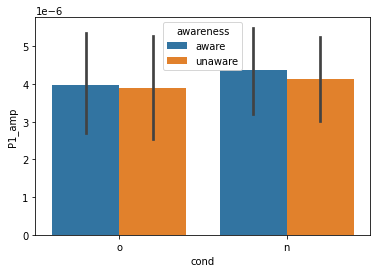

In [44]:
import seaborn as sns
sns.barplot(data=df,x='cond',y='P1_amp',hue='awareness')

<AxesSubplot:xlabel='cond', ylabel='P1_amp'>

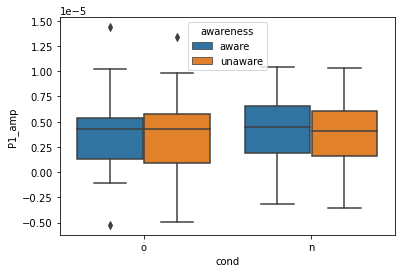

In [45]:
sns.boxplot(data=df,x='cond',y='P1_amp',hue='awareness')